# Import necessary modules

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import io
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2025-01-03 18:09:28.500788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.optimizers import SGD

In [3]:
#Loading dataset
dataDir = './data'
csvfiles = os.listdir(dataDir)
df = pd.DataFrame()

dFrames = []

#iterate through all the files, read it and combine the data
for fname in csvfiles:
    if(fname.split(".")[1] == 'csv'):
        df = pd.read_csv(os.path.join(dataDir, fname), low_memory=False, index_col=None, header=0)
        dFrames.append(df)
        print("Read file {}".format(fname))

df = pd.concat(dFrames, axis=0, ignore_index=True)

print("Finisehd loading files")

Read file metasploitable-2.csv
Read file Normal_data.csv
Read file OVS.csv
Finisehd loading files


In [4]:
print(df.head())
print(df['Label'].value_counts())

                                    Flow ID         Src IP  Src Port  \
0  192.168.3.130-200.175.2.130-38694-4444-6  192.168.3.130     38694   
1  192.168.3.130-200.175.2.130-38693-4444-6  192.168.3.130     38693   
2  192.168.3.130-200.175.2.130-3632-33747-6  200.175.2.130     33747   
3  192.168.3.130-200.175.2.130-8180-38745-6  200.175.2.130     38745   
4  192.168.3.130-200.175.2.130-8180-37217-6  200.175.2.130     37217   

          Dst IP  Dst Port  Protocol       Timestamp  Flow Duration  \
0  200.175.2.130      4444         6  10/1/2020 5:02         269709   
1  200.175.2.130      4444         6  10/1/2020 5:02         268599   
2  192.168.3.130      3632         6  10/1/2020 5:02          22194   
3  192.168.3.130      8180         6  10/1/2020 1:39           9556   
4  192.168.3.130      8180         6  10/1/2020 1:39           8782   

   Tot Fwd Pkts  Tot Bwd Pkts  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0             4             5  ...                 0       

In [5]:
allZeroColumns = ['Bwd Pkts/b Avg','Bwd Byts/b Avg','Fwd Blk Rate Avg','Fwd Seg Size Min','Fwd Pkts/b Avg', 'Fwd Byts/b Avg', 'Fwd URG Flags', 'ECE Flag Cnt', 'CWE Flag Count', 'Fwd PSH Flags', 'Bwd Blk Rate Avg','Init Fwd Win Byts']
df.drop(labels=allZeroColumns, axis='columns', inplace=True)

## Replace space with "_"
In order to avoid future conflicts, we need to replace spaces with underscores.

In [6]:
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_') )
df.columns = cols
print(df.head())

                                    Flow_ID         Src_IP  Src_Port  \
0  192.168.3.130-200.175.2.130-38694-4444-6  192.168.3.130     38694   
1  192.168.3.130-200.175.2.130-38693-4444-6  192.168.3.130     38693   
2  192.168.3.130-200.175.2.130-3632-33747-6  200.175.2.130     33747   
3  192.168.3.130-200.175.2.130-8180-38745-6  200.175.2.130     38745   
4  192.168.3.130-200.175.2.130-8180-37217-6  200.175.2.130     37217   

          Dst_IP  Dst_Port  Protocol       Timestamp  Flow_Duration  \
0  200.175.2.130      4444         6  10/1/2020 5:02         269709   
1  200.175.2.130      4444         6  10/1/2020 5:02         268599   
2  192.168.3.130      3632         6  10/1/2020 5:02          22194   
3  192.168.3.130      8180         6  10/1/2020 1:39           9556   
4  192.168.3.130      8180         6  10/1/2020 1:39           8782   

   Tot_Fwd_Pkts  Tot_Bwd_Pkts  ...  Fwd_Act_Data_Pkts  Active_Mean  \
0             4             5  ...                  2          0.0   


## Checking for null and INFINITE

In [7]:
#replace infinit number
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

#drop null
df.dropna(how = 'all')

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Fwd_Act_Data_Pkts,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,192.168.3.130-200.175.2.130-38694-4444-6,192.168.3.130,38694,200.175.2.130,4444,6,10/1/2020 5:02,269709,4,5,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
1,192.168.3.130-200.175.2.130-38693-4444-6,192.168.3.130,38693,200.175.2.130,4444,6,10/1/2020 5:02,268599,2,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
2,192.168.3.130-200.175.2.130-3632-33747-6,200.175.2.130,33747,192.168.3.130,3632,6,10/1/2020 5:02,22194,5,5,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
3,192.168.3.130-200.175.2.130-8180-38745-6,200.175.2.130,38745,192.168.3.130,8180,6,10/1/2020 1:39,9556,4,4,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
4,192.168.3.130-200.175.2.130-8180-37217-6,200.175.2.130,37217,192.168.3.130,8180,6,10/1/2020 1:39,8782,4,4,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343884,172.17.0.2-200.175.2.130-80-55440-6,200.175.2.130,55440,172.17.0.2,80,6,25/12/2019 05:19:55 PM,296,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Attack
343885,172.17.0.2-200.175.2.130-80-55446-6,200.175.2.130,55446,172.17.0.2,80,6,25/12/2019 05:20:00 PM,3431,2,5,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Attack
343886,172.17.0.2-200.175.2.130-80-55446-6,200.175.2.130,55446,172.17.0.2,80,6,25/12/2019 05:20:00 PM,4121,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Attack
343887,172.17.0.2-200.175.2.130-80-55456-6,200.175.2.130,55456,172.17.0.2,80,6,25/12/2019 05:20:05 PM,5887,2,5,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Attack


## Checking Data type

In [8]:
print('Data type of each column of Dataframe :')
df.info(verbose=True)

Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 72 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow_ID            343889 non-null  object 
 1   Src_IP             343889 non-null  object 
 2   Src_Port           343889 non-null  int64  
 3   Dst_IP             343889 non-null  object 
 4   Dst_Port           343889 non-null  int64  
 5   Protocol           343889 non-null  int64  
 6   Timestamp          343889 non-null  object 
 7   Flow_Duration      343889 non-null  int64  
 8   Tot_Fwd_Pkts       343889 non-null  int64  
 9   Tot_Bwd_Pkts       343889 non-null  int64  
 10  TotLen_Fwd_Pkts    343889 non-null  float64
 11  TotLen_Bwd_Pkts    343889 non-null  float64
 12  Fwd_Pkt_Len_Max    343889 non-null  int64  
 13  Fwd_Pkt_Len_Min    343889 non-null  int64  
 14  Fwd_Pkt_Len_Mean   343889 non-null  float64
 15  Fwd_Pkt_Len

## Drop all column contain object datatype exept Label
Drop Timestamp, Flow_id, Src_ip and Dst_ip columns as they contain object datatype and will not be usefull in traning model. 

In [9]:
df = df.drop(columns=['Timestamp', 'Flow_ID', 'Src_IP', 'Dst_IP'])
print('Timestamp, ', 'Flow_ID, ', 'Src_IP, ', 'Dst_IP, ', "columns are dropped")

Timestamp,  Flow_ID,  Src_IP,  Dst_IP,  columns are dropped


## Modify Label column
Label column consists of the main values which defines waether the data in the raw discribe attach or not. In order to convert from object to numaric, first look in to data exists in the column.

In [10]:
print(df['Label'].value_counts())

Probe         98129
DDoS          73529
Normal        68424
DoS           53616
DDoS          48413
BFA            1405
Web-Attack      192
BOTNET          164
U2R              17
Name: Label, dtype: int64


As we can see there are only two values present. Now we can use binary method to catogaries the data as below.
<br>benign --> 0
<br>DDoS attacks --> 1

In [11]:
df.loc[df['Label'] == 'DDoS ', 'Label'] = 'DDoS'

In [12]:
# label encoding
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

df['Label'].value_counts()

2    121942
5     98129
4     68424
3     53616
0      1405
7       192
1       164
6        17
Name: Label, dtype: int64

In [13]:
df["Label"].astype('float')
print(df['Label'].value_counts())

2    121942
5     98129
4     68424
3     53616
0      1405
7       192
1       164
6        17
Name: Label, dtype: int64


## Converting categorical variables to integers

In [14]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print(cat_cols)

cat_cols = df.select_dtypes(include='object').columns
print(cat_cols)

print('Data type of each column of Dataframe :')
df.info(verbose=True)

Index([], dtype='object')
Index([], dtype='object')
Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 68 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Src_Port           343889 non-null  int64  
 1   Dst_Port           343889 non-null  int64  
 2   Protocol           343889 non-null  int64  
 3   Flow_Duration      343889 non-null  int64  
 4   Tot_Fwd_Pkts       343889 non-null  int64  
 5   Tot_Bwd_Pkts       343889 non-null  int64  
 6   TotLen_Fwd_Pkts    343889 non-null  float64
 7   TotLen_Bwd_Pkts    343889 non-null  float64
 8   Fwd_Pkt_Len_Max    343889 non-null  int64  
 9   Fwd_Pkt_Len_Min    343889 non-null  int64  
 10  Fwd_Pkt_Len_Mean   343889 non-null  float64
 11  Fwd_Pkt_Len_Std    343889 non-null  float64
 12  Bwd_Pkt_Len_Max    343889 non-null  int64  
 13  Bwd_Pkt_Len_Min    343889 non-null  int64  
 14  Bwd_Pkt_

## Creating train_df dataset

In [15]:
# Shuffle the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select a subset of the data for training
num_data = 343889 # can change between 500 and 1152382
train_df = df.iloc[:num_data].copy() # Use .iloc to avoid a SettingWithCopyWarning


print('Data type of each column of Dataframe :')
train_df.info(verbose=True)

Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 68 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Src_Port           343889 non-null  int64  
 1   Dst_Port           343889 non-null  int64  
 2   Protocol           343889 non-null  int64  
 3   Flow_Duration      343889 non-null  int64  
 4   Tot_Fwd_Pkts       343889 non-null  int64  
 5   Tot_Bwd_Pkts       343889 non-null  int64  
 6   TotLen_Fwd_Pkts    343889 non-null  float64
 7   TotLen_Bwd_Pkts    343889 non-null  float64
 8   Fwd_Pkt_Len_Max    343889 non-null  int64  
 9   Fwd_Pkt_Len_Min    343889 non-null  int64  
 10  Fwd_Pkt_Len_Mean   343889 non-null  float64
 11  Fwd_Pkt_Len_Std    343889 non-null  float64
 12  Bwd_Pkt_Len_Max    343889 non-null  int64  
 13  Bwd_Pkt_Len_Min    343889 non-null  int64  
 14  Bwd_Pkt_Len_Mean   343889 non-null  float64
 15  Bwd_Pkt_Len

# Split dataset

In [16]:
train_size = int(0.7 * len(train_df))
test_size = int(0.30 * len(train_df))

train_data = train_df.iloc[:train_size, :]
test_data = train_df.iloc[train_size:, :]

# Generate sequences

In [17]:
# Define sequence length and overlap
seq_length = 10 # Sequence length
seq_overlap = 5 # Overlap between sequences

# Function to generate sequences
def generate_sequences(data):
    seqs = []
    for i in range(0, len(data) - seq_length + 1, seq_overlap):
        seqs.append(data.iloc[i:i+seq_length, :])
    return seqs

scaler = StandardScaler()
train_seqs_tmp = scaler.fit_transform(train_data)
test_seqs_tmp = scaler.fit_transform(test_data)

# Generate sequences for train, validation, and test sets
train_seqs = generate_sequences(pd.DataFrame(train_seqs_tmp))
test_seqs = generate_sequences(pd.DataFrame(test_seqs_tmp))

# pad sequences

In [18]:
# Function to pad sequences
def pad_sequences(seqs):
    padded_seqs = []
    for seq in seqs:
        if len(seq) < seq_length:
            padded_seq = np.concatenate((seq, np.zeros((seq_length-len(seq), len(df.columns)))), axis=0)
        else:
            padded_seq = seq
        padded_seqs.append(padded_seq)
    return np.array(padded_seqs)

# Pad sequences for train, validation, and test sets
train_seqs = pad_sequences(train_seqs)
test_seqs = pad_sequences(test_seqs)

# Reshape input

In [19]:
# Reshape input
train_X = np.reshape(train_seqs, (train_seqs.shape[0], train_seqs.shape[1], len(train_df.columns)))
test_X = np.reshape(test_seqs, (test_seqs.shape[0], test_seqs.shape[1], len(train_df.columns)))

# Convert labels to categorical

In [20]:
# Convert labels to categorical
train_y = to_categorical(train_data["Label"].values[:train_X.shape[0]])
test_y = to_categorical(test_data["Label"].values[:test_X.shape[0]])

In [21]:
train_X = train_X.astype('float32')
train_y = train_y.astype('float32')
test_y = test_y.astype('float32')


In [22]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(48143, 10, 68) (48143, 8) (20632, 10, 68) (20632, 8)


# LSTM Autoencoder

In [23]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, RepeatVector, TimeDistributed
from keras.optimizers import SGD

In [24]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(48143, 10, 68) (48143, 8) (20632, 10, 68) (20632, 8)


In [25]:
train_X.shape[1:][1]

68

In [26]:
n_features = len(df.columns) # number of features in the dataset

# Define model architecture
from keras.layers import Activation

input_seq = Input(shape=train_X.shape[1:])
encoded = LSTM(64, activation='sigmoid', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(units=64, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(train_X.shape[1:][1]))(decoded)  #67 features
autoencoder = Model(input_seq, decoded)
                          
autoencoder.compile(optimizer='adam', loss='BinaryCrossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 68)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                34048     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            33024     
                                                                 
 time_distributed (TimeDistr  (None, 10, 68)           4420      
 ibuted)                                                         
                                                                 
Total params: 71,492
Trainable params: 71,492
Non-trainable p

2025-01-03 18:09:44.214512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 18:09:44.216658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 18:09:44.218760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [27]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=80, verbose=1)
history = autoencoder.fit(train_X, train_X, epochs=30, batch_size=100, validation_split=0.1, callbacks=[early_stop])
history

Epoch 1/30


2025-01-03 18:09:44.689537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 18:09:44.692178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 18:09:44.693854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

433/434 [============================>.] - ETA: 0s - loss: 0.0943

2025-01-03 18:09:54.021056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 18:09:54.023625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 18:09:54.025000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

434/434 [==============================] - 10s 17ms/step - loss: 0.0941 - val_loss: 0.2020
Epoch 2/30
434/434 [==============================] - 7s 15ms/step - loss: 0.1915 - val_loss: 0.1228
Epoch 3/30
434/434 [==============================] - 7s 15ms/step - loss: 0.0182 - val_loss: -0.0320
Epoch 4/30
434/434 [==============================] - 7s 16ms/step - loss: -0.0388 - val_loss: -0.0855
Epoch 5/30
434/434 [==============================] - 6s 15ms/step - loss: -0.1144 - val_loss: -0.1472
Epoch 6/30
434/434 [==============================] - 10s 22ms/step - loss: -0.0683 - val_loss: -0.0877
Epoch 7/30
434/434 [==============================] - 11s 26ms/step - loss: -0.1201 - val_loss: -0.1018
Epoch 8/30
434/434 [==============================] - 8s 18ms/step - loss: -0.0870 - val_loss: 0.0869
Epoch 9/30
434/434 [==============================] - 8s 18ms/step - loss: -0.0338 - val_loss: -0.1372
Epoch 10/30
434/434 [==============================] - 9s 21ms/step - loss: -0.1327 - v

In [28]:
autoencoder.save('./models/lstmAutoModel.h5')

## LOSS Chart

<function matplotlib.pyplot.show(close=None, block=None)>

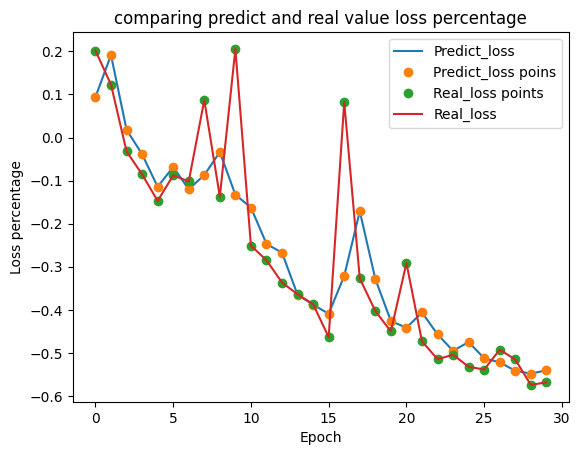

In [29]:
#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.plot(history.history['val_loss'])
plt.title('comparing predict and real value loss percentage')
plt.ylabel('Loss percentage')
plt.xlabel('Epoch')
plt.legend(['Predict_loss','Predict_loss poins','Real_loss points', 'Real_loss'])
plt.show

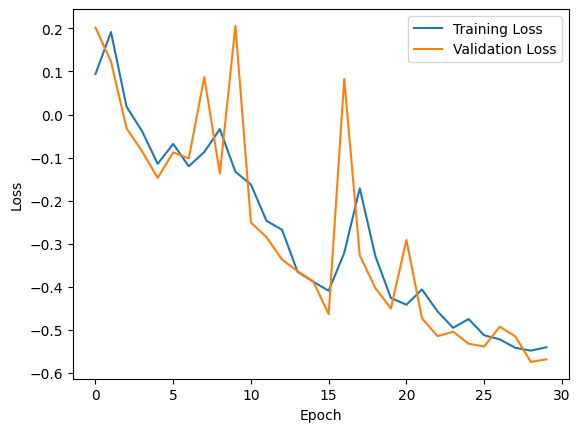

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

In [31]:
import datetime as dt
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def predictAndPlot(model, X_test, Y_test):
    start = dt.datetime.now()

    #escore = model.evaluate(X_test, Y_test, batch_size=32)
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=-1)  # Get the class with the highest probability
    pred = np.argmax(pred, axis=-1)  # Get the class with the highest probability

    y_eval = np.argmax(Y_test,axis=1)   

    score = metrics.accuracy_score(y_eval, pred)
    rscore = recall_score(y_eval, pred, average='weighted')
    ascore = precision_score(y_eval, pred, average='weighted')
    f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

    lb = preprocessing.LabelBinarizer()
    lb.fit(y_eval)
    y_eval = lb.transform(y_eval)
    pred = lb.transform(pred)
    roc_score = roc_auc_score(y_eval, pred)
    #roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)

    print('Printing Summary')
    print('===================================')    
    print('Time taken:',dt.datetime.now()-start)
    print("Validation score: {}".format(score))
    #print("Evaluation score: {}".format(escore))
    print("Recall score: {}".format(rscore))
    print("Precision score: {}".format(ascore))
    print("F1 Measure score: {}".format(f1score))
    print("ROC-AUC score: {}".format(roc_score))
    
    #Now plot
    pred = np.argmax(pred,axis=1)
    y_test = Y_test.argmax(axis=1)
    confMat = confusion_matrix(y_test, pred)
    cm_df = pd.DataFrame(confMat)

    labels = ['DDoS', 'Probe', 'Normal', 'DoS', 'BFA', 'Web-Attack', 'BOTNET', 'U2R']
    sns.set(rc = {'figure.figsize':(15,10)})
    sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')

    plt.show() 

   1/1505 [..............................] - ETA: 12:52

2025-01-03 18:14:24.906852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 18:14:24.909279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 18:14:24.910702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1505/1505 [==============================] - 6s 4ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Printing Summary
Time taken: 0:00:07.222877
Validation score: 0.0793261741063083
Recall score: 0.0793261741063083
Precision score: 0.27500502906329516
F1 Measure score: 0.11851637922338504
ROC-AUC score: 0.4963738908670916


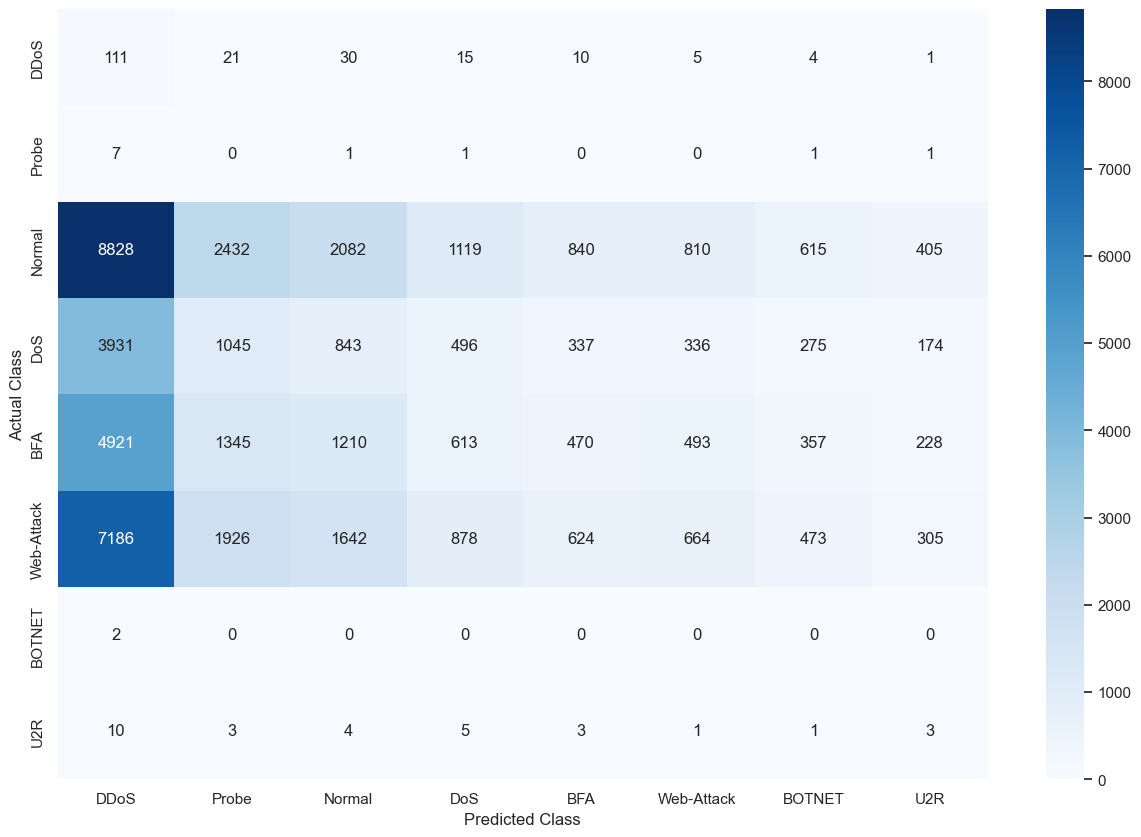

In [32]:
predictAndPlot(autoencoder, train_X, train_y)